In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree, remove_self_loops, add_self_loops
from torch_geometric.nn import GATConv

class GATNet(nn.Module):
    def __init__(self):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(dataset.num_features, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8*8, dataset.num_classes, dropout=0.6)

    def forward(self, data):
        x = F.dropout(data.x, p=0.4, training=self.training)
        x = F.relu(self.conv1(x, data.edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, data.edge_index)
        return F.log_softmax(x, dim=1)

In [1]:
pip install torch_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.3 MB/s eta 0:00:00


In [3]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='./dataset/Citeseer', name='CiteSeer')


Processing...
Done!


In [6]:
import os
import torch
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATNet().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Ensure directory exists
directory = 'LossAndAccuracy'
os.makedirs(directory, exist_ok=True)

filename = 'LossAndAccuracy/GAT_Citeseer.txt'

model.train()
for epoch in range(2000):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / data.test_mask.sum().item()

    with open(filename,'a') as f: # 'a' means append, which means continuing to write data after the original file content (the original data is not clear)
        f.write('{:02d} {:.4f} {:.4f}\n'.format(epoch, loss, acc))

Test Model

In [7]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.6650


Draw Curve

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
data_cora =np.loadtxt("LossAndAccuracy/GAT_Citeseer.txt")

x = data_cora[:,0] # epoch
y1 = data_cora[:,1] # loss
y2 = data_cora[:,2] # accuracy

Text(0.5, 1.0, 'loss for training GAT on citeseer')

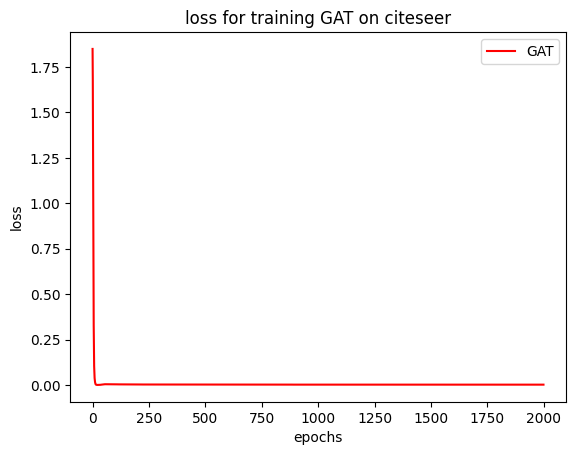

In [9]:
# Draw the overall loss curve

p2 = pl.plot(x, y1,'r-', label = u'GAT')
pl.legend()

pl.xlabel(u'epochs')
pl.ylabel(u'loss')
plt.title('loss for training GAT on citeseer')

Text(0.5, 1.0, 'accuracy for training GAT on citeseer')

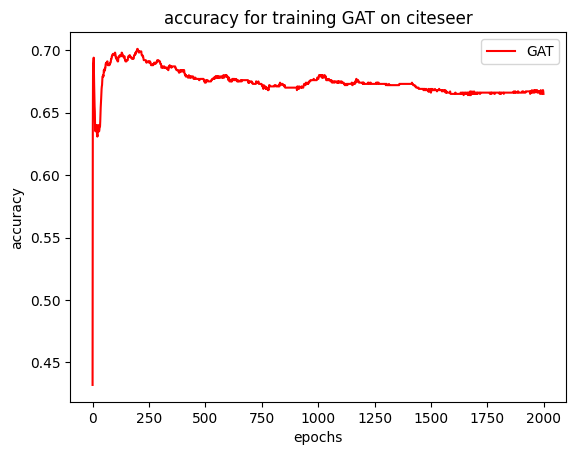

In [10]:
# Draw the overall accuracy curve

p2 = pl.plot(x, y2,'r-', label = u'GAT')
pl.legend()

pl.xlabel(u'epochs')
pl.ylabel(u'accuracy')
plt.title('accuracy for training GAT on citeseer')

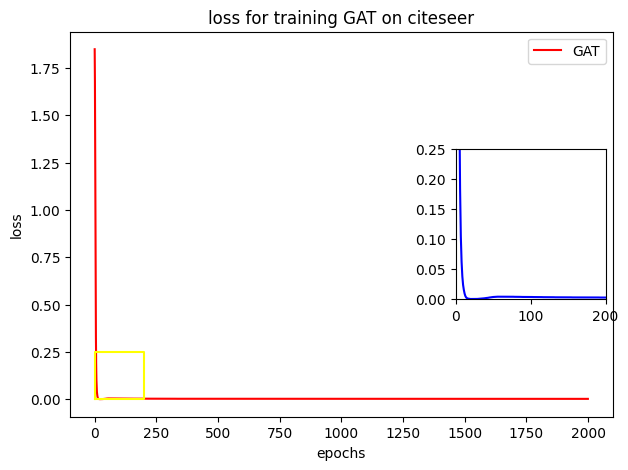

In [11]:
fig1 = plt.figure(figsize = (7,5)) # figsize is the size of the image
ax1 = fig1.add_subplot(1, 1, 1) # ax1 is the name of the subgraph

# Draw the overall loss curve
p2 = pl.plot(x, y1,'r-', label = u'GAT')
pl.legend()

pl.xlabel(u'epochs')
pl.ylabel(u'loss')
plt.title('loss for training GAT on citeseer')

# Show an enlarged portion of the curve
tx0 = 0
tx1 = 200
ty0 = 0.000
ty1 = 0.25
sx = [tx0,tx1,tx1,tx0,tx0]
sy = [ty0,ty0,ty1,ty1,ty0]
pl.plot(sx,sy,"yellow")
axins = inset_axes(ax1, width=1.5, height=1.5, loc='right')

axins.plot(x,y1, color='blue', ls='-')
axins.axis([0, 200, 0.000, 0.25])
pl.show()

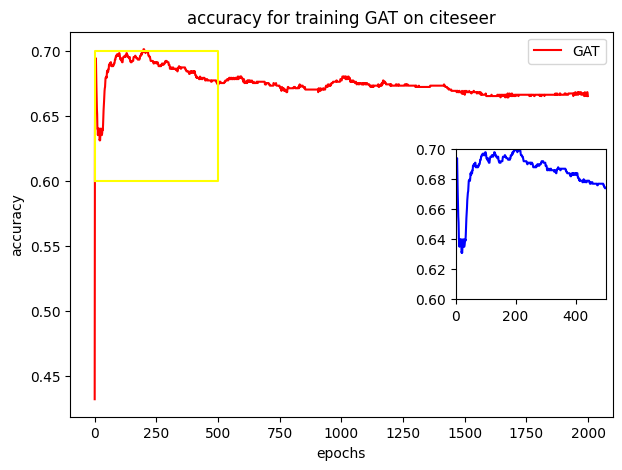

In [12]:
fig1 = plt.figure(figsize = (7,5)) # figsize is the size of the picture
ax1 = fig1.add_subplot(1, 1, 1) # ax1 is the name of the subgraph

# Draw the overall accuracy curve
p2 = pl.plot(x, y2,'r-', label = u'GAT')
pl.legend()

pl.xlabel(u'epochs')
pl.ylabel(u'accuracy')
plt.title('accuracy for training GAT on citeseer')

# Show an enlarged portion of the curve
tx0 = 0
tx1 = 500
#Set the abscissa range of the area you want to enlarge
ty0 = 0.60
ty1 = 0.70
#Set the vertical coordinate range of the area you want to enlarge
sx = [tx0,tx1,tx1,tx0,tx0]
sy = [ty0,ty0,ty1,ty1,ty0]
pl.plot(sx,sy,"yellow")
axins = inset_axes(ax1, width=1.5, height=1.5, loc='right')

axins.plot(x,y2, color='blue', ls='-')
axins.axis([0, 500, 0.60, 0.70])
pl.show()

In [13]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.att_src 	 torch.Size([1, 8, 8])
conv1.att_dst 	 torch.Size([1, 8, 8])
conv1.bias 	 torch.Size([64])
conv1.lin.weight 	 torch.Size([64, 3703])
conv2.att_src 	 torch.Size([1, 1, 6])
conv2.att_dst 	 torch.Size([1, 1, 6])
conv2.bias 	 torch.Size([6])
conv2.lin.weight 	 torch.Size([6, 64])
Optimizer's state_dict:
state 	 {0: {'step': tensor(2000.), 'exp_avg': tensor([[[-1.3696e-07, -2.1193e-08, -1.9387e-07, -2.7394e-08, -6.0985e-08,
          -6.4118e-08, -5.0697e-08, -6.7053e-08],
         [ 1.1565e-06,  8.4957e-08,  3.1097e-07, -2.2303e-07,  7.0722e-08,
           6.6004e-07,  3.7804e-07,  2.7331e-07],
         [ 1.5043e-14, -3.9115e-12, -9.9504e-14,  1.0842e-15, -4.9860e-14,
           1.6913e-12, -2.4058e-12,  4.8409e-12],
         [-4.0240e-13, -2.5356e-12,  3.2666e-11,  3.4770e-13, -7.9282e-12,
           2.2576e-11, -3.2743e-13,  2.9914e-11],
         [-1.4998e-14,  5.9807e-13,  1.3849e-14,  1.1410e-11,  2.6571e-12,
           5.6951e-12, -1.5489e-12,  1.604

In [14]:
torch.save(model.state_dict(),'GATciteseer.pkl')

Spectral Clustering

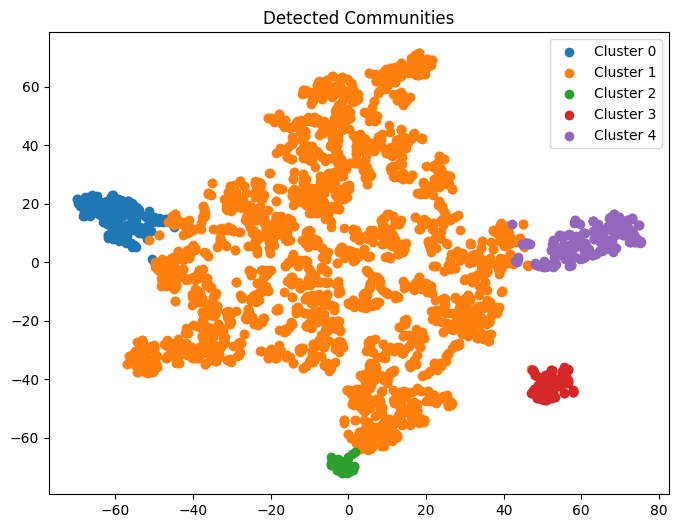

In [15]:
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Step 1: Extract features from the trained GAT model
model.eval()
with torch.no_grad():
    # Call the forward method of conv1 and conv2 separately, passing the edge_index
    x = model.conv1(data.x, data.edge_index)
    x = F.relu(x)
    x = F.dropout(x, p=0.6, training=False)
    x = model.conv2(x, data.edge_index)

# Step 2: Perform spectral clustering
# Assuming num_clusters is the number of clusters you want to detect
num_clusters = 5  # You can adjust this according to your dataset
sc = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors', random_state=0)
cluster_labels = sc.fit_predict(x.cpu().numpy())

# Step 3: Visualize the detected communities
# You can use dimensionality reduction techniques like t-SNE for visualization
tsne = TSNE(n_components=2, random_state=0)
embedded_features = tsne.fit_transform(x.cpu().numpy())

plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    plt.scatter(embedded_features[cluster_labels == i, 0], embedded_features[cluster_labels == i, 1], label=f'Cluster {i}')
plt.title('Detected Communities')
plt.legend()
plt.show()

In [43]:
import numpy as np
import networkx as nx

# Assuming 'G' is the graph and 'predicted_labels' contains the predicted cluster labels
# You need to define 'G' and 'predicted_labels' appropriately based on your data
# 'predicted_labels' should contain cluster labels assigned to each node

# Example:
# G = ...  # Define your graph
# predicted_labels = ...  # Define predicted cluster labels for each node

# Define the graph 'G' and predicted cluster labels 'predicted_labels'
# For demonstration purposes, let's create a random graph and random cluster labels
num_nodes = 100
G = nx.gnp_random_graph(num_nodes, 0.1)
predicted_labels = np.random.randint(0, 5, size=num_nodes)  # Assuming 5 clusters

# Compute communities
communities = [set(np.where(predicted_labels == i)[0]) for i in np.unique(predicted_labels)]

# Compute density
num_edges_within_communities = sum(len(G.subgraph(community).edges()) for community in communities)
num_nodes_within_communities = sum(len(community) for community in communities)
total_possible_edges_within_communities = num_nodes_within_communities * (num_nodes_within_communities - 1) / 2
density = num_edges_within_communities / total_possible_edges_within_communities

# Compute entropy
num_nodes = len(predicted_labels)
unique_labels, label_counts = np.unique(predicted_labels, return_counts=True)
proportions = label_counts / num_nodes
entropy = -np.sum(proportions * np.log(proportions))

# Compute modularity
num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
modularity = nx.algorithms.community.modularity(G, [set(np.where(predicted_labels == i)[0]) for i in np.unique(predicted_labels)])

# Compute conductance
cut_size = sum(nx.algorithms.cuts.cut_size(G, community, G.nodes - set(community)) for community in communities)
volume = sum(nx.algorithms.cuts.volume(G, community) for community in communities)
if volume == 0:  # Avoid division by zero
    conductance = float('inf')
else:
    conductance = cut_size / volume

# Print the results
print(f"Overall: Density={density:.4f}, Entropy={entropy:.4f}, Modularity={modularity:.4f}, Conductance={conductance:.4f}")


Overall: Density=0.0218, Entropy=1.5569, Modularity=-0.0023, Conductance=0.7809


In [ ]:
# Step 4: Compute ARI and NMI
# Assuming true_labels are the ground truth labels
true_labels = data.y.cpu().numpy()
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print(f'Adjusted Rand Index (ARI): {ari}')
print(f'Normalized Mutual Information (NMI): {nmi}')

Adjusted Rand Index (ARI): 0.04358458773109929
Normalized Mutual Information (NMI): 0.18737986603471413


K means Clustering (Finding K using elbow method)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

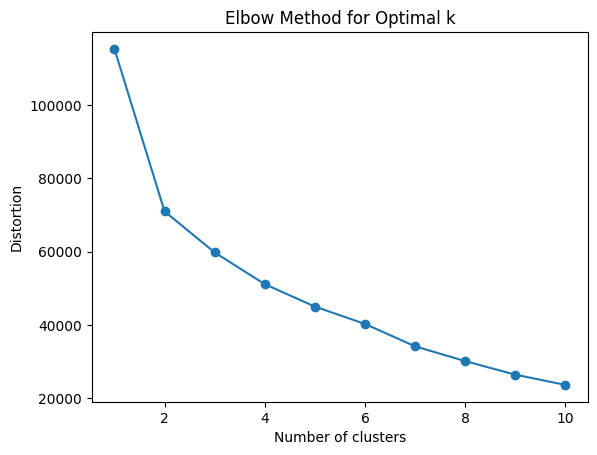

In [46]:
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Extract output features from the GAT model
with torch.no_grad():
    model.eval()
    output_features = model(data).cpu().numpy()

# Step 2: Perform K-means clustering
def kmeans_clustering(features, k):
    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(features)
    return clusters

# Step 3: Utilize the elbow method to determine the optimal value of K
def elbow_method(features, max_k=10):
    distortions = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(features)
        distortions.append(kmeans.inertia_)
    plt.plot(range(1, max_k + 1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal k')
    plt.show()

elbow_method(output_features)

# Step 4: Visualize the detected communities
def visualize_clusters(features, clusters):
    # Visualization code here, depending on the dimensionality of features
    # For example, if features are 2D, you can scatter plot them and color them based on clusters
    plt.scatter(features[:, 0], features[:, 1], c=clusters, cmap='viridis')
    plt.title('Detected Communities')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


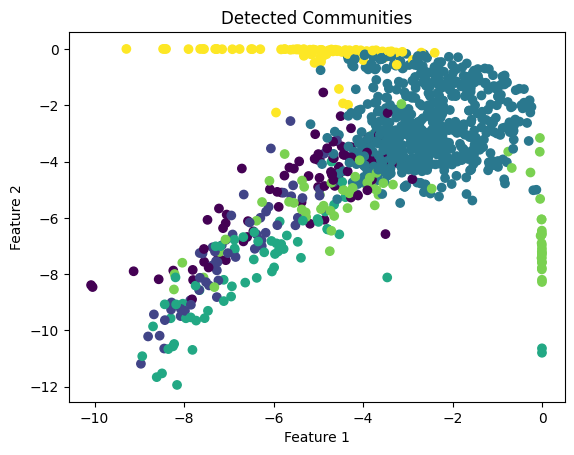

In [47]:
# Choose the optimal value of K based on the elbow method
optimal_k = 6  # Adjust this based on the elbow method plot

# Perform K-means clustering with the optimal value of K
clusters = kmeans_clustering(output_features[data.test_mask], optimal_k)

#Visualize the detected communities
visualize_clusters(output_features[data.test_mask], clusters)

In [60]:
from sklearn.metrics import pairwise_distances
from scipy.stats import entropy

# Step 1: Compute density
def compute_density(cluster_labels, adjacency_matrix):
    num_edges_within_community = np.sum(adjacency_matrix[np.ix_(cluster_labels, cluster_labels)]) / 2
    num_nodes = len(cluster_labels)
    total_possible_edges = num_nodes * (num_nodes - 1) / 2
    density = num_edges_within_community / total_possible_edges
    return density

# Step 2: Compute entropy
def compute_entropy(cluster_labels, node_labels):
    unique_labels, label_counts = np.unique(node_labels[cluster_labels], return_counts=True)
    label_probabilities = label_counts / np.sum(label_counts)
    entropy_value = entropy(label_probabilities)
    return entropy_value

# Step 3: Compute modularity
def compute_modularity(cluster_labels, adjacency_matrix):
    num_nodes = len(cluster_labels)
    degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))
    total_edges = np.sum(adjacency_matrix) / 2
    inner_edges = np.sum(adjacency_matrix[np.ix_(cluster_labels, cluster_labels)]) / 2
    expected_edges = (np.sum(degree_matrix[np.ix_(cluster_labels, cluster_labels)]) / (2 * total_edges)) ** 2
    modularity = (inner_edges / total_edges) - expected_edges
    return modularity

# Step 4: Compute conductance
def compute_conductance(cluster_labels, adjacency_matrix):
    num_nodes = len(cluster_labels)
    inner_edges = np.sum(adjacency_matrix[np.ix_(cluster_labels, cluster_labels)])
    boundary_edges = np.sum(adjacency_matrix[np.ix_(cluster_labels, ~cluster_labels)])
    if inner_edges + boundary_edges == 0:
        conductance = 0  # Handle the case where the community has no edges
    else:
        conductance = boundary_edges / (inner_edges + boundary_edges)
    return conductance

# Assuming 'clusters' contains the cluster labels assigned by K-means
# 'output_features' contains the output features from the GAT model
# 'data' contains the graph data

# Adjacency matrix of the graph
adjacency_matrix = torch.sparse.FloatTensor(data.edge_index, torch.ones(data.edge_index.shape[1]), (data.num_nodes, data.num_nodes)).to_dense().numpy()

# Initialize combined cluster mask
combined_cluster_mask = np.zeros(data.num_nodes, dtype=bool)

# Compute metrics for all clusters combined
for cluster_id in range(optimal_k):
    cluster_mask = clusters == cluster_id
    combined_cluster_mask[data.test_mask] |= cluster_mask

# Compute metrics for the combined clusters
density = compute_density(combined_cluster_mask, adjacency_matrix)
entropy_value = compute_entropy(np.where(combined_cluster_mask)[0], data.y.cpu().numpy())
modularity = compute_modularity(combined_cluster_mask, adjacency_matrix)
conductance = compute_conductance(combined_cluster_mask, adjacency_matrix)

print(f"Overall Metrics: Density={density:.4f}, Entropy={entropy_value:.4f}, Modularity={modularity:.4f}, Conductance={conductance:.4f}")


Overall Metrics: Density=0.0001, Entropy=1.7490, Modularity=-0.0027, Conductance=0.7025


In [ ]:
# Calculate Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI)
# Ground truth labels for evaluation (assuming available)
ground_truth_labels = data.y.numpy()[data.test_mask]
ari = adjusted_rand_score(ground_truth_labels, clusters)
nmi = normalized_mutual_info_score(ground_truth_labels, clusters)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)

Adjusted Rand Index (ARI): 0.06391806724928947
Normalized Mutual Information (NMI): 0.2269151953921674


Louvain Method

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


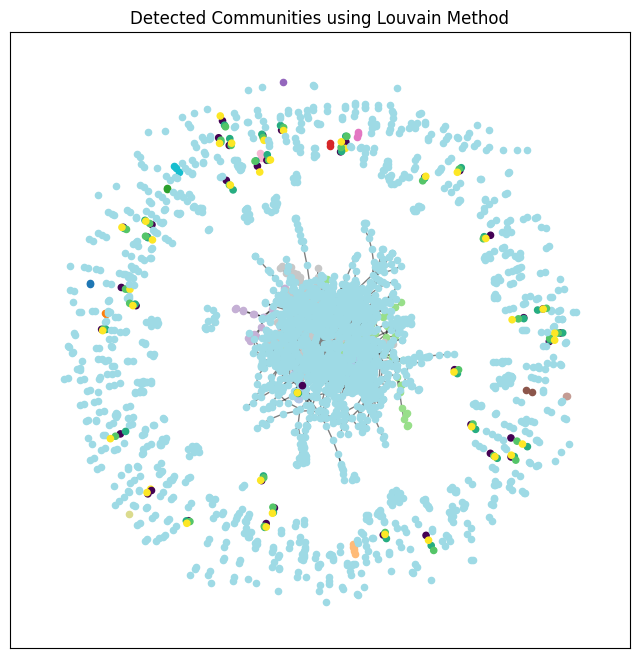

Adjusted Rand Index (ARI): 0.09294202222454014
Normalized Mutual Information (NMI): 0.3278421735984628


In [62]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv
from torch_geometric.utils import to_networkx
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import community.community_louvain as community_louvain

# Assuming `model` is already defined and trained
# Assuming `data` contains your dataset

# Step 1: Extract features from the trained GAT model
model.eval()
with torch.no_grad():
    output_features = model(data).cpu().numpy()

# Step 2: Convert PyG graph to NetworkX graph
graph = to_networkx(data, to_undirected=True)

# Step 3: Apply community detection using Louvain method
partition = community_louvain.best_partition(graph)

# Step 4: Visualize the detected communities
pos = nx.spring_layout(graph)  # positions for all nodes
plt.figure(figsize=(8, 8))
# Draw nodes for each community with a different color
for community_id in set(partition.values()):
    nodes_in_community = [node for node, comm_id in partition.items() if comm_id == community_id]
    nx.draw_networkx_nodes(graph, pos, nodelist=nodes_in_community, node_size=20, node_color=plt.cm.tab20(community_id))
# Draw edges
nx.draw_networkx_edges(graph, pos, alpha=0.5)
plt.title('Detected Communities using Louvain Method')
plt.show()

# Step 5: Calculate ARI and NMI
# Assuming ground truth communities are available in data.y
ground_truth = data.y.numpy()
ari = adjusted_rand_score(ground_truth, list(partition.values()))
nmi = normalized_mutual_info_score(ground_truth, list(partition.values()))

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)


In [71]:
import numpy as np
import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.community.quality import modularity

# Assuming `partition` is the detected community partition

# Convert partition to the format expected by modularity function
communities = {}
for node, comm_id in partition.items():
    if comm_id not in communities:
        communities[comm_id] = []
    communities[comm_id].append(node)

# Step 1: Compute density for each community
community_density = {}
for comm_id, nodes_in_community in communities.items():
    subgraph = graph.subgraph(nodes_in_community)
    density_ = nx.density(subgraph)
    community_density[comm_id] = density_

# Step 2: Compute entropy for the community partition
def calculate_entropy(partition):
    values = list(partition.values())
    unique_values, counts = np.unique(values, return_counts=True)
    probabilities = counts / len(partition)
    entropy_ = -np.sum(probabilities * np.log(probabilities))
    return entropy_

entropy_ = calculate_entropy(partition)

# Step 3: Compute modularity for the community partition
modularity_ = modularity(graph, list(communities.values()))

# Step 4: Compute conductance for each community
community_conductance = {}
for comm_id, nodes_in_community in communities.items():
    volume_community = nx.volume(graph, nodes_in_community)
    if volume_community == 0:
        conductance_ = 1.0  # Set conductance to a default value for empty communities
    else:
        conductance_ = nx.algorithms.cuts.conductance(graph, nodes_in_community)
    community_conductance[comm_id] = conductance_

# Overall Density
overall_density = sum(density * len(nodes) for nodes, density in zip(communities.values(), community_density.values())) / len(graph.edges())

# Overall Entropy
overall_entropy = entropy_

# Overall Modularity
overall_modularity = modularity_

# Overall Conductance
total_volume_cut = sum(len(nodes) * volume for nodes, volume in zip(communities.values(), community_conductance.values()))
total_volume_all = sum(len(nodes) for nodes in communities.values())
overall_conductance = total_volume_cut / total_volume_all

# Print or use the computed overall metrics as needed
print("Overall Density:", overall_density)
print("Overall Entropy:", overall_entropy)
print("Overall Modularity:", overall_modularity)
print("Overall Conductance:", overall_conductance)



Overall Density: 0.203085149518711
Overall Entropy: 4.818895926185249
Overall Modularity: 0.8871167215168037
Overall Conductance: 0.06073659159120979
